<a href="https://colab.research.google.com/github/BELBINBENORM/my_kaggle_ml_practice/blob/main/26.01.00.Predicting_Student_test_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Student Test Scores
---
####Playground Series - Season 6 Episode 1



`Upload Kaggle API key (one-time per session)`

- Go to Kaggle → Account → API → Create New Token
- Download kaggle.json

Now run the below code

In [1]:
# Upload kaggle.json when prompted
from google.colab import files
files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c playground-series-s6e1

# Unzip files
!unzip -o playground-series-s6e1.zip



Saving kaggle.json to kaggle.json
  0% 0.00/13.8M [00:00<?, ?B/s]
100% 13.8M/13.8M [00:00<00:00, 1.60GB/s]
Archive:  playground-series-s6e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

In [34]:
raw_train_df=pd.read_csv("train.csv")
raw_test_df=pd.read_csv("test.csv")

## EDA

In [35]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [36]:
raw_df = raw_train_df.drop_duplicates()
X = raw_df.drop(columns=['id','exam_score'])
y = raw_df['exam_score']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)
X_test = raw_test_df.drop(columns=['id'])

num_col = X_train.select_dtypes(include='number').columns
cat_col = X_train.select_dtypes(exclude='number').columns

In [37]:
# Target

y_train.describe()

,exam_score
count,504000.000000
mean,62.482335
std,18.931347
min,19.599000
25%,48.800000
50%,62.500000
75%,76.200000
max,100.000000


<Axes: >

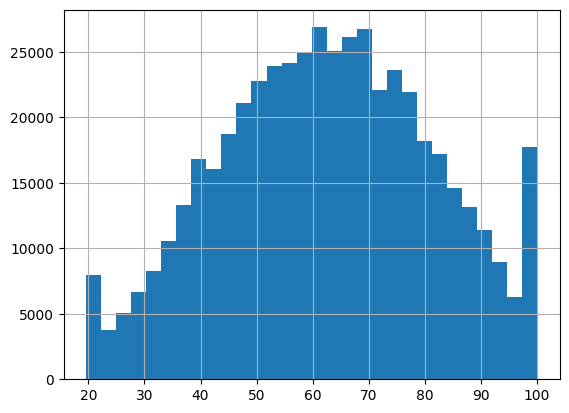

In [38]:
y_train.hist(bins=30)

In [39]:
# Numeric columns

X_train[num_col].describe()

,age,study_hours,class_attendance,sleep_hours
count,504000.000000,504000.000000,504000.000000,504000.000000
mean,20.543137,3.999017,71.983240,7.072504
std,2.260777,2.359695,17.434645,1.744139
min,17.000000,0.080000,40.600000,4.100000
25%,19.000000,1.970000,57.000000,5.600000
50%,21.000000,4.000000,72.600000,7.100000
75%,23.000000,6.050000,87.200000,8.600000
max,24.000000,7.910000,99.400000,9.900000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'study_hours'}>],
       [<Axes: title={'center': 'class_attendance'}>,
        <Axes: title={'center': 'sleep_hours'}>]], dtype=object)

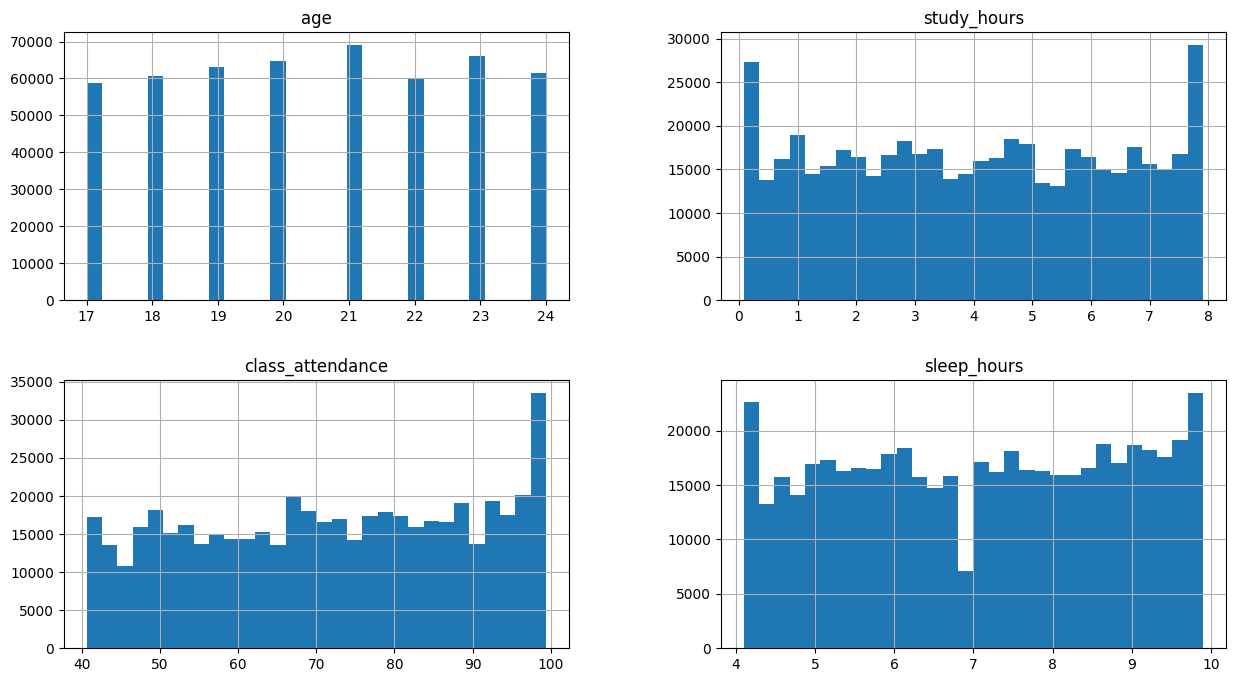

In [40]:
X_train[num_col].hist(bins=30,figsize=(15,8))

In [41]:
X_train[cat_col].describe()

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,504000,504000,504000,504000,504000,504000,504000
unique,3,7,2,3,5,3,3
top,other,b.tech,yes,poor,coaching,medium,moderate
freq,168857,104999,463589,170995,105425,171078,282941


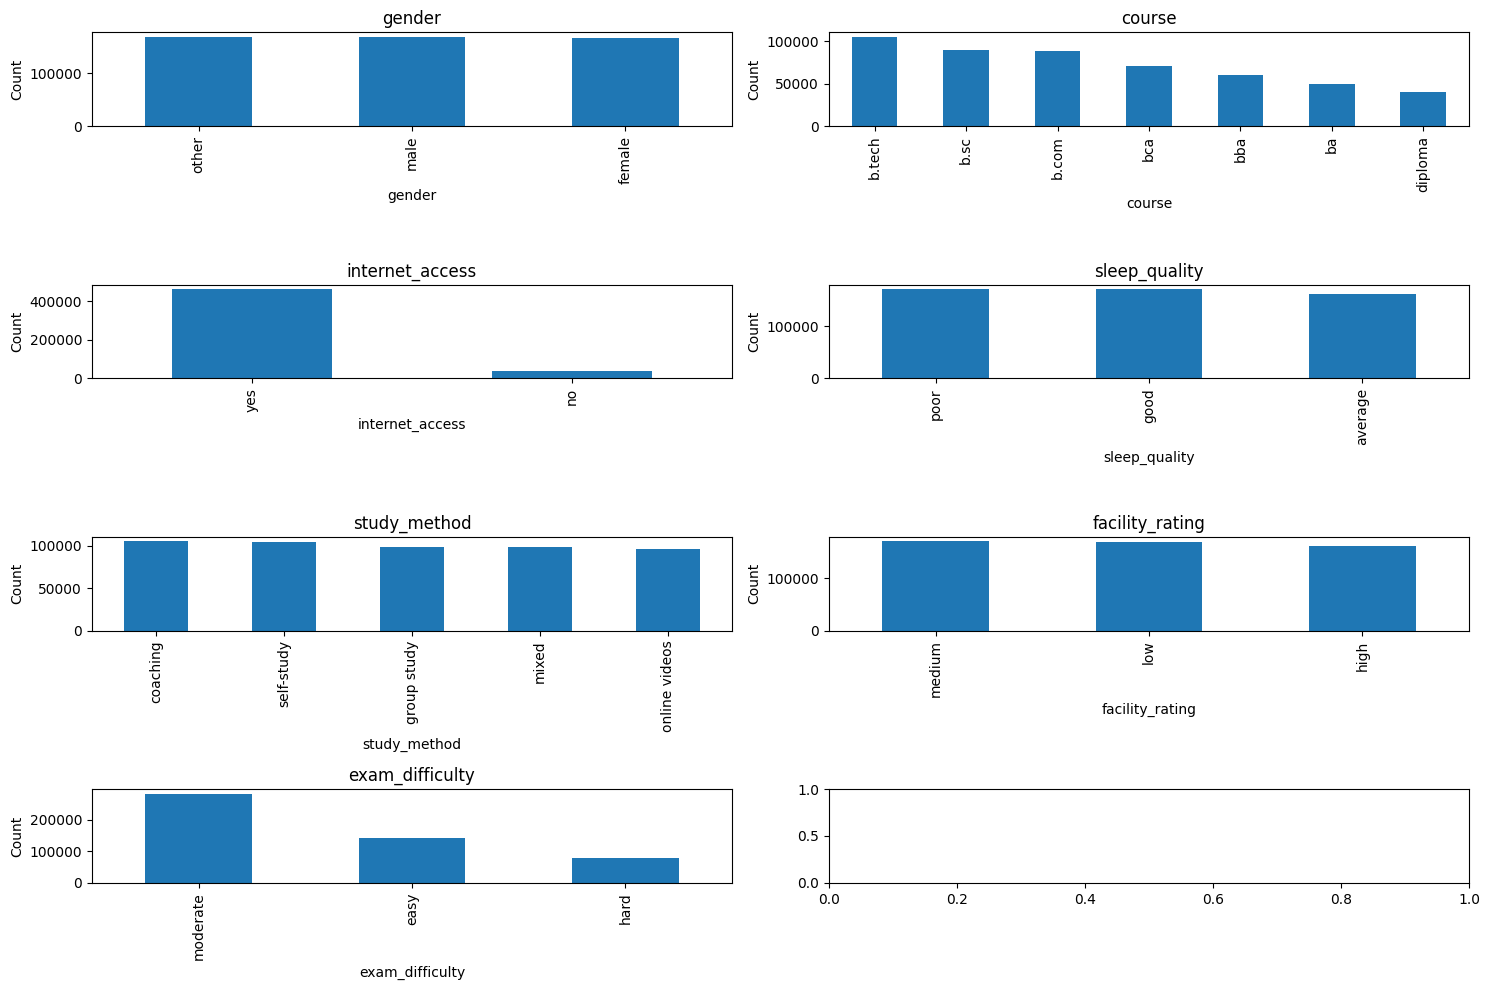

In [42]:

fig,axes = plt.subplots(4,2,figsize=(15,10))
axes = axes.flatten()

for col, ax in zip(cat_col,axes):
  X_train[col].value_counts().plot(ax=ax,kind='bar')
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

## preprocessing

In [43]:
class Featur_Enginering(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass

  def fit(self,X,y=None):
    return self

  def transform(self,X):
    X = X.copy()

    X["low_sleep"] = (X["sleep_hours"] < 6).astype(int)

    X["very_low_sleep"] = (X["sleep_hours"] < 5).astype(int)

    X["hard_exam"] = (X["exam_difficulty"] == "hard").astype(int)

    X["hard_exam_sleep"] = X["hard_exam"] * X["sleep_hours"]

    X["attendance_pressure"] = 1 - X["class_attendance"]

    X["study_pressure"] = X["study_hours"] * X["attendance_pressure"]

    X["cognitive_load"] = X["study_hours"] / (X["sleep_hours"] + 1)

    X["study_efficiency"] = X["study_hours"] * X["class_attendance"]

    X["sleep_study_ratio"] = (X["sleep_hours"] / (X["study_hours"] + 1e-6))

    X["attendance_pressure"] = 1 - X["class_attendance"]

    X["age_group"] = pd.cut(X["age"],
                            bins=[0, 18, 22, 30, 100],
                            labels=["school", "college", "postgrad", "adult"])

    return X


num_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("Normalizer",StandardScaler())
])

cat_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("Encoding",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

normalizer = ColumnTransformer([
    ("num",num_normalizer,make_column_selector(dtype_include=np.number)),
    ("cat",cat_normalizer,make_column_selector(dtype_exclude=np.number))
])


In [71]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [74]:

Model = Pipeline([
    ("Feature Enginering",Featur_Enginering()),
    ("Normalizer",normalizer),
    ("model",HistGradientBoostingRegressor(max_depth=6,
                                           learning_rate=0.05,
                                           max_iter=300,
                                           random_state=42))
])

In [66]:
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10],
    "model__l1_ratio": [0.2, 0.5, 0.8]
}

In [67]:
grid = GridSearchCV(Model,
                    param_grid,
                    scoring='neg_root_mean_squared_error',
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

In [75]:
Model.fit(X_train,y_train)

Pipeline(steps=[('Feature Enginering', Featur_Enginering()),
                ('Normalizer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Normalizer',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ba4abd26210>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ba4abd262d0>)])),
                ('model',
                 HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                               max_iter=300,
                                               random_state=42))])

In [76]:
y_pred = Model.predict(X_val)

In [77]:
from sklearn.metrics import  mean_squared_error

mse = mean_squared_error(y_val, y_pred)
print("Validation RMSE:", np.sqrt(mse))

Validation RMSE: 8.796299879512679


In [28]:
submission=pd.DataFrame({'id':raw_test_df['id'],
                         'exam_score':grid.predict(X_test)})

submission.to_csv("submission_ridge.csv", index=False)

In [ ]:
score : 8.87044

|Grid Model|val_RMSE|test_RMSE|
|-|-|-|
|Ridge(alpha=np.float64(1.0))|8.88514|8.87044|
|Lasso(alpha=0.001, max_iter=5000, random_state=42)|8.88500|-|
|ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=5000, random_state=42)|8.88496|-|
|HistGradientBoostingRegressor(max_depth=6,learning_rate=0.05,max_iter=300,random_state=42)|8.79629|-|